In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from d2l import torch as d2l
import numpy as np

d2l.init_Seed()
device = d2l.get_device()

GPU ready!


In [2]:
config = {
    "m": 100,
    "n": 2,
    "batch_size": 10,
    "n_epochs": 60,
    "optimizer": "SGD",
    # "optimizer": "Adam",
    # "optimizer": "Adagrad",
    # "optimizer": "Adadelta",
    "optim_hparas": {
        'lr': 0.5,         # for SGD and Adam
#         'momentum': 0.9,
#         'nesterov':True
    }
}

In [3]:
def synthetic_data(m_examples, n_features, mean=1, std=1.5, bias=0):
    X = torch.cat([torch.normal(mean, std, (m_examples, n_features)),
                   torch.normal(-mean, std, (m_examples, n_features))], 0) + bias
    y = torch.zeros(m_examples * 2)
    y[:m_examples] = 1

    return X, y

def initial(config, mean=2, std=1.5, bias=0):
    m, n = config["m"], config['n']

    return synthetic_data(m, n, mean, std, bias)

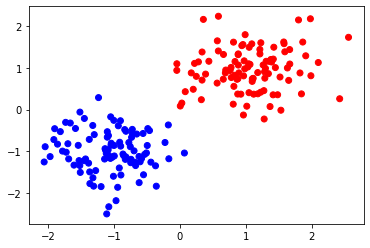

In [4]:
X, y = initial(config, mean=1, std=0.5, bias=0)

fig, ax = plt.subplots()
ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y, cmap='bwr')

In [5]:
def prep_dataloader(X, y, mode, batch_size):
    dataset = data.TensorDataset(X, y)
    return data.DataLoader(dataset, batch_size, shuffle=(mode == 'train'))

In [6]:
tr_set = prep_dataloader(X, y, 'train', config['batch_size'])

In [7]:
class Logreg(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.net = nn.Sequential(nn.Linear(n_features, 1), nn.Sigmoid())
        
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=0.01)

        # self.net[0].weight.data.fill_(-1.5)
        self.net[0].weight.data = torch.tensor([[-1., -1.]])

        self.net[0].bias.data.fill_(0)


    def forward(self, X):
        return self.net(X).squeeze(1)


In [8]:
def train(model, tr_set, te_set, loss, optimizer, scheduler=None, device='cpu', n_epochs=10, early_stop=5):
    epoch = 0

    loss_record = {"train": [], "dev": []}
    trace = [model.net[0].weight.data.cpu().numpy().copy()[0]]

    animator = d2l.Animator(xlabel='epoch', xlim=[1, n_epochs], ylim=[0, 1], 
                            legend=['train loss', 'train acc'])

    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            l = loss(model(X), y)
            l.backward()
            optimizer.step()
            # model.net[0].weight.data[0][1] = 1

            loss_record['train'].append(l.detach().cpu().item())
            trace.append(model.net[0].weight.data.cpu().numpy().copy()[0])

        epoch += 1
        
        train_l, train_acc = dev(model, te_set, loss)
        animator.add(epoch, (train_l, train_acc))
#       print(f"epoch: {epoch:3d}, train loss: {train_l: .4f}")

    return trace, loss_record

In [9]:
def accuracy(y_hat, y):
    cmp = (y_hat > 0.5) == y
    return float(cmp.sum())

In [10]:
def dev(model, dv_set, loss):
    model.eval()

    metric = torch.zeros(3)

    for X, y in dv_set:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(X)
            metric += torch.tensor([loss(y_hat, y).cpu().item() * len(y), accuracy(y_hat, y),  y.numel()])
    
    return float(metric[0] / metric[2]), float(metric[1] / metric[2])

In [11]:
loss = nn.BCELoss(reduction='mean')
# loss = nn.MSELoss(reduction='mean')
model = Logreg(config["n"]).to(device)
optimizer = getattr(torch.optim, config["optimizer"])(
    model.parameters(), **config["optim_hparas"]
)

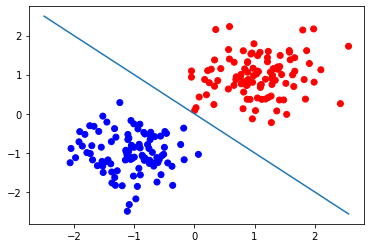

In [12]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y, cmap='bwr')
x = np.linspace(X.min().item(), X.max().item(), 2)
w_init = model.net[0].weight.data[0].cpu().numpy()
b_init = model.net[0].bias.data[0].cpu().numpy()
ax.plot(x, (-x * w_init[0] - b_init) / w_init[1])

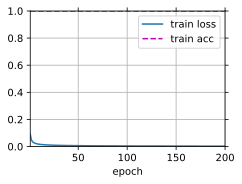

In [13]:
trace, loss_record = train(model, tr_set, tr_set, loss, optimizer, device=device, n_epochs=config["n_epochs"])

In [14]:
w = model.net[0].weight.data[0].cpu().numpy()
b = model.net[0].bias.data[0].cpu().numpy()
w, b

(array([5.5817184, 5.8225155], dtype=float32), array(1.2405635, dtype=float32))

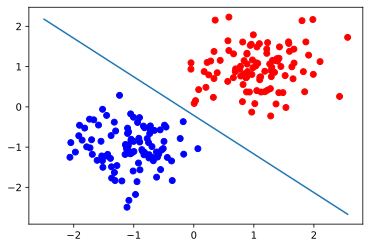

In [15]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y, cmap='bwr')
x = np.linspace(X.min().item(), X.max().item(), 2)
ax.plot(x, (-x * w[0] - b) / w[1])

In [16]:
def visualization(loss, trace=None):
    fig = plt.figure(figsize=(12, 6))

    gs = GridSpec(2, 2, width_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[:, 1], projection='3d')
    ax2 = fig.add_subplot(gs[:, 0])

    
    def loss_wrt_wgts(w1, w2):
        w = torch.Tensor([w1, w2])
        y_hat = nn.Sigmoid()(X @ w)
        return loss(y_hat, y)
    
    loss_wgts = np.vectorize(loss_wrt_wgts)
    x1, x2 = np.meshgrid(np.linspace(-10, 10, 100),
                         np.linspace(-10, 10, 100))
    z = loss_wgts(x1, x2)


    ax1.plot_surface(x1, x2, z, cmap='tab20c', alpha=0.8)

    if trace:
        ax1.plot3D(*zip(*trace), [loss(nn.Sigmoid()(X @ w), y) for w in trace], c='r', marker='o')

    ax1.set_title('Loss Surface', fontsize=16)
    ax1.set_xlabel('w1') 
    ax1.set_ylabel('w2')
    ax1.set_zlabel('Loss')
    ax1.view_init(30, -10)


    ax2.contour(x1, x2, z, 30, colors='#1f77b4')
    if trace:
        ax2.plot(*zip(*trace), '-o', color='#ff7f0e')

    # ax2.axes.get_xaxis().set_visible(False)
    # ax2.axes.get_yaxis().set_visible(False)
    ax2.set_title('Loss Contour', fontsize=16)
    ax2.set_xlabel('w1') 
    ax2.set_ylabel('w2')
#     ax2.legend()
    ax2.axis('equal')

    plt.show()

In [ ]:
visualization(nn.BCELoss(), trace)

In [ ]:
# visualization(nn.MSELoss(), trace)

In [ ]:
model.net[0].weight.data[0]

In [ ]:
# model.train()
# for X, y in tr_set:
#     optimizer.zero_grad()
#     X, y = X.to(device), y.to(device)
#     l = loss(model(X), y)

#     print(l.detach().cpu())
#     print(model.net[0].weight.grad)

#     l.backward()
#     optimizer.step()
#     break

In [ ]:
loss_record['train'][-10:]

In [ ]:
model.net[0].bias.data[0]